In [1]:
# pylint: disable=wildcard-import, method-hidden
# pylint: enable=too-many-lines

In [2]:
import mxnet 
from mxnet.gluon import nn
from mxnet import gluon, image, npx,np
import matplotlib.pyplot as plt
import numpy
from mxnet.gluon.data.vision import transforms
import cv2
from PIL import Image
from mxnet.gluon.model_zoo import vision
import os
import pandas as pd
import numpy
from mxnet.gluon import nn
from mxnet import init,autograd
npx.set_np()
import sklearn 
import statsmodels
import plotly

In [3]:
import json
import plotly.graph_objects as go 
from pathlib import Path
from IPython import display
%matplotlib inline
npx.set_np()

In [4]:
nab = Path.cwd()/r'../NAB'
data_path = nab/r'data'
labels_filepath = nab/r'labels/combined_labels.json'

In [5]:
training_filename =r'realAWSCloudwatch/rds_cpu_utilization_cc0c53.csv'

valid_filename = r'realAWSCloudwatch/rds_cpu_utilization_e47b3b.csv'

In [6]:
with open(labels_filepath,'r') as f:
    anomalies_timestamps = json.load(f)
    train_data_anomalies = anomalies_timestamps[training_filename]
    valid_data_anomalies = anomalies_timestamps[valid_filename]
    #print(train_data_anomalies, valid_data_anomalies)



In [7]:
train_pd = pd.read_csv(data_path/training_filename)
valid_pd = pd.read_csv(data_path/valid_filename)
print(train_pd.head(), valid_pd.head())

             timestamp  value
0  2014-02-14 14:30:00  6.456
1  2014-02-14 14:35:00  5.816
2  2014-02-14 14:40:00  6.268
3  2014-02-14 14:45:00  5.816
4  2014-02-14 14:50:00  5.862              timestamp   value
0  2014-04-10 00:02:00  14.012
1  2014-04-10 00:07:00  13.334
2  2014-04-10 00:12:00  15.000
3  2014-04-10 00:17:00  13.998
4  2014-04-10 00:22:00  14.332


In [8]:
def normalization(data):
    mean = data.mean(keepdims=False)
    var = ((data-mean)**2).mean(keepdims=False)
    normalized_data = (data-mean)/np.sqrt(var)
    return normalized_data
    

In [9]:
#train and validation  data 
train_value = np.array(train_pd['value'])
valid_value = np.array(valid_pd['value'])

train_pd['normalize value'] =(normalization(train_value))
valid_pd['normalize value'] =(normalization(valid_value))




In [10]:
train_anomalies = train_pd[train_pd['timestamp'].isin(train_data_anomalies)]
valid_anomalies = valid_pd[valid_pd['timestamp'].isin(valid_data_anomalies)]

In [11]:
train_anomalies

,timestamp,value,normalize value
3080,2014-02-25 07:15:00,25.1033,4.652448549480584
3579,2014-02-27 00:50:00,19.1650,3.0264414585940704


In [12]:
def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')


In [13]:
def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

In [14]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

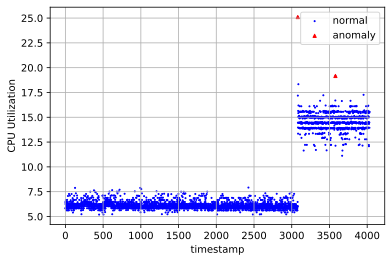

In [15]:
set_figsize((6,4))

axes = plt.gca()
axes.scatter(train_pd.iloc[:,0],train_pd.iloc[:,1],marker='.',s=5,c='blue' )
axes.scatter(train_anomalies.iloc[:,0],train_anomalies.iloc[:,1],marker='^',s=10,c='red')
set_axes(axes, xlabel='timestamp', ylabel='CPU Utilization', xlim=None, ylim=None, xscale='linear', yscale='linear', legend=['normal','anomaly'])

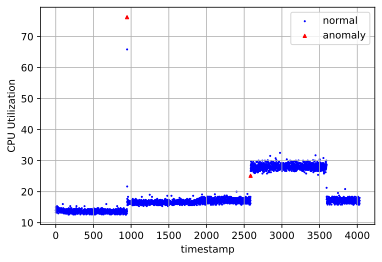

In [16]:
set_figsize((6,4))

axes = plt.gca()
axes.scatter(valid_pd.iloc[:,0],valid_pd.iloc[:,1],marker='.',s=5,c='blue' )
axes.scatter(valid_anomalies.iloc[:,0],valid_anomalies.iloc[:,1],marker='^',s=10,c='red')
set_axes(axes, xlabel='timestamp', ylabel='CPU Utilization', xlim=None, ylim=None, xscale='linear', yscale='linear', legend=['normal','anomaly'])

In [17]:

from mxnet.gluon.data import Dataset,dataloader


In [18]:

class Load_data(Dataset):
    def __init__(self, data: pd.DataFrame, size:int, step:int=1):
        self.T = int(data['normalize value'].count())
        self.step=step
        self.size = size+1
        self.chunks = np.zeros(shape=(self.T-self.size,self.size),dtype=np.float32)
        for i in range(self.size):
            self.chunks[:,i] = data['normalize value'][i:i+self.T-self.size]
        self.chunks.reshape(-1,1,self.size)
        self.chunks= self.chunks[::self.step]
    def __len__(self):
        return (self.chunks.shape[0]//self.step)
    
    def __getitem__(self,i):
        x = self.chunks[i,:-1]
        y = self.chunks[i,-1:]
        return x,y.squeeze()
    def get_all_data(self):
        return self.chunks[:,:-1],self.chunks[:,-1:]

In [19]:
n_factors = 10
train_ds = Load_data(train_pd, n_factors)
valid_ds = Load_data(valid_pd, n_factors)

In [20]:
train_array = train_ds.get_all_data()
valid_array = valid_ds.get_all_data()

dtype('float32')

In [21]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a Gluon data iterator."""
    dataset = gluon.data.ArrayDataset(*data_arrays)
    return gluon.data.DataLoader(dataset, batch_size, shuffle=is_train)

In [22]:
train_array[0].shape

(4021, 10)

In [55]:
batch_size =100
train_iter= load_array(train_array,batch_size,is_train=True)
valid_iter= load_array(valid_array,batch_size, is_train=False)

In [56]:
#next(iter(train_iter))

In [57]:

def conv_layer(out_feat,kernel_size=5, strides=1,padding=2, relu=True,**kwargs):
    
    res=nn.Sequential()
    with res.name_scope():
        res.add( nn.Conv1D(out_feat,kernel_size=kernel_size,padding=padding,strides=strides,use_bias=False))
        res.add(nn.BatchNorm())
        if relu:
            res.add(nn.Activation('relu'))
    return res


In [58]:
class resblock(nn.Block):
    def __init__(self,in_feat,out_feat,**kwargs):
        super().__init__(**kwargs)
        self.in_feat=in_feat
        self.out_feat=out_feat

        self.conv1 = conv_layer(self.out_feat)
        
        self.conv2 = conv_layer(self.out_feat,relu=False)
        
        if self.in_feat!=self.out_feat:
            self.shortcut = conv_layer(self.out_feat,kernel_size=1,padding=0,relu=False)
            
    def forward(self,x):
        self.o = self.conv1(x)
        if self.in_feat!=self.out_feat:
            x = self.shortcut(x)
        return x + self.conv2(self.o)

    


In [59]:

def c_n_n(out_size):
    
    base = nn.Sequential()
    with base.name_scope():
        base.add(resblock(1,8))        
        base.add(resblock(8,8))        
        base.add(resblock(8,16))
        base.add(resblock(16,16))
        base.add(resblock(16,32))
        base.add(resblock(32,32))
        base.add(resblock(32,64))
        base.add(resblock(64,64))
        
    head = nn.Sequential()
    with head.name_scope():
        head.add(nn.MaxPool1D(3))
        head.add(nn.Flatten())
        head.add(nn.Dense(out_size))
    finish_model = nn.Sequential()
    with finish_model.name_scope():
        finish_model.add(base)
        finish_model.add(head)
    return finish_model

In [60]:
xy=c_n_n(1)



In [61]:
import time

In [62]:
def train_model(net, train_iter,valid_array,device=npx.cpu,epochs=13,lr=1e-1):
    losses_data = {'train':[],'time':[],'valid':[]}
    

    net.initialize(force_reinit=True, init= init.Normal())
    loss = gluon.loss.L2Loss()
    trainer = gluon.Trainer(net.collect_params(), 'Adam',{'learning_rate':lr})
    
    for epoch in range(epochs):
        t1= time.time()
        ll = 0.0
        for i ,(X,y) in enumerate(train_iter):
            
            #X,y = X.as_in_ctx(device),y.as_in_ctx(device)
            with autograd.record():
                #print(X.shape, y.shape)
                y_hat= net(X.reshape(X.shape[0],1,-1))
                #print(y_hat.shape)
                l= loss(y_hat.reshape(y.shape),y)
            l.backward()
            trainer.step(X.shape[0])
            ll+=l.mean()
        t2=time.time()
        losses_data['time'].append(t2-t1)
        losses_data['train'].append(ll) 

        vloss= loss(net(valid_array[0].reshape(valid_array[0].shape[0],1,-1)),valid_array[1].reshape(-1)).mean()
        losses_data['valid'].append(vloss)
        print(f'({epoch+1}) train: {ll}, valid: {vloss}, time: {t2-t1}')
    return losses_data

    
    

In [63]:
valid_array[1], train_array[1]

(array([[-0.9993525 ],
        [-0.6938835 ],
        [-0.99970937],
        ...,
        [-0.3309606 ],
        [-0.33051455],
        [-0.47860992]]),
 array([[-0.5148329 ],
        [-0.56083417],
        [-0.56412   ],
        ...,
        [ 1.7445127 ],
        [ 2.0165224 ],
        [ 1.5966516 ]]))

In [64]:
t = train_model(xy,train_iter,valid_array)

(1) train: 332.2560119628906, valid: 0.4538857936859131, time: 1.0442047119140625
(2) train: 11.676780700683594, valid: 0.16324912011623383, time: 1.089085340499878
(3) train: 3.879986047744751, valid: 0.09257267415523529, time: 1.1788454055786133
(4) train: 1.5217480659484863, valid: 0.10090334713459015, time: 1.4052412509918213
(5) train: 0.9271690249443054, valid: 0.07517626881599426, time: 1.1728630065917969
(6) train: 0.7554004192352295, valid: 0.05969500541687012, time: 1.3583664894104004
(7) train: 2.147785186767578, valid: 0.17358450591564178, time: 1.1329667568206787
(8) train: 3.414220094680786, valid: 0.08429154753684998, time: 1.440145492553711
(9) train: 1.1328155994415283, valid: 0.2909506559371948, time: 1.2496559619903564
(10) train: 5.905174255371094, valid: 0.1475851982831955, time: 1.4012503623962402
(11) train: 2.999211072921753, valid: 0.08651141077280045, time: 1.5398995876312256
(12) train: 1.4163771867752075, valid: 0.06875395029783249, time: 1.1618914604187012


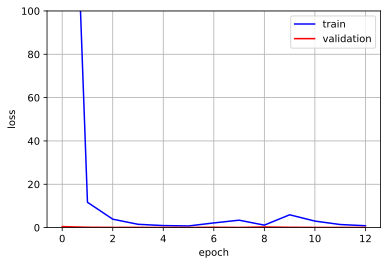

In [65]:
set_figsize((6,4))
epochs= 13
axes = plt.gca()
axes.plot(range(epochs),t['train'],c='blue' )
axes.plot(range(epochs),t['valid'],c='red')
axes.set_ylim(0,100)
set_axes(axes, xlabel='epoch', ylabel='loss', xlim=None, ylim=None, xscale='linear', yscale='linear', legend=['train','validation'])

In [66]:
y_hat= xy(valid_array[0].reshape(valid_array[0].shape[0],1,-1))

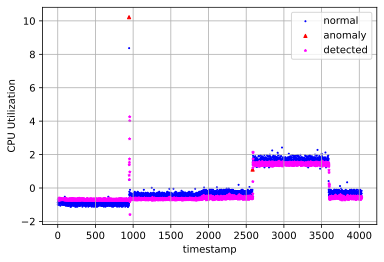

In [67]:
set_figsize((6,4))

axes = plt.gca()
axes.scatter(valid_pd.iloc[:,0],valid_pd.iloc[:,2],marker='.',s=5,c='blue' )
axes.scatter(valid_anomalies.iloc[:,0],valid_anomalies.iloc[:,2],marker='^',s=10,c='red')
axes.scatter(valid_pd.iloc[11:,0],y_hat.reshape(-1),marker='*',s=5,c='magenta')
set_axes(axes, xlabel='timestamp', ylabel='CPU Utilization', xlim=None, ylim=None, xscale='linear', yscale='linear', legend=['normal','anomaly','detected'])

In [68]:
valid_pd.count()

timestamp          4032
value              4032
normalize value    4032
dtype: int64

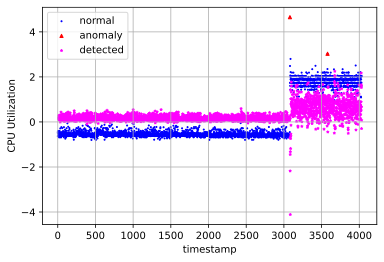

In [54]:
y_hat= xy(train_array[0].reshape(train_array[0].shape[0],1,-1))
set_figsize((6,4))

axes = plt.gca()
axes.scatter(train_pd.iloc[:,0],train_pd.iloc[:,2],marker='.',s=5,c='blue' )
axes.scatter(train_anomalies.iloc[:,0],train_anomalies.iloc[:,2],marker='^',s=10,c='red')
axes.scatter(train_pd.iloc[11:,0],y_hat.reshape(-1),marker='*',s=5,c='magenta')
set_axes(axes, xlabel='timestamp', ylabel='CPU Utilization', xlim=None, ylim=None, xscale='linear', yscale='linear', legend=['normal','anomaly','detected'])